# Center Loss in Keras

### Item recognition 'the sequel' - using Center Loss with Transfer Learning

Using InceptionV3

The implementation of **Center Loss** came from: [handongfeng/MNIST-center-loss](https://github.com/handongfeng/MNIST-center-loss/blob/master/centerLoss_MNIST.py)

**Articles:**
- [A Discriminative Feature Learning Approach for Deep Face Recognition](https://ydwen.github.io/papers/WenECCV16.pdf)
- [Understanding Center Loss Based Network for Image Retrieval with Few Training Data](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11132/Ghosh_Understanding_Center_Loss_Based_Network_for_Image_Retrieval_with_Few_ECCVW_2018_paper.pdf)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook
%load_ext tensorboard

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.preprocessing import image_dataset_from_directory # cant import in Tensorflow v2.2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#import os

In [4]:
from centerLoss import prelu, zero_loss, my_model
from centerLoss import CenterLossLayer

In [5]:
from utils import tbProjector, PCAPlotter, create_testdata

In [6]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [7]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Counting Training Data 

In [8]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print(x_train.shape)

In [9]:
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization, Activation
#from tensorflow.keras.layers import Dropout, Flatten, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [10]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)

train_classnum = len(os.listdir(train_dir))
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [11]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [12]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 64

## Setup train data generator

In [13]:
'''
train_ds = image_dataset_from_directory(
    directory='image_data/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=_BATCH_SIZE,
    image_size=(224, 224))
'''

"\ntrain_ds = image_dataset_from_directory(\n    directory='image_data/train',\n    labels='inferred',\n    label_mode='categorical',\n    batch_size=_BATCH_SIZE,\n    image_size=(224, 224))\n"

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'image_data/train',
    target_size=(224, 224),
    batch_size=_BATCH_SIZE,
    class_mode='categorical'
    ) 

Found 12070 images belonging to 706 classes.


In [15]:
def plot_dataset(image_samples):

    #plt.figure(figsize=(5, 2))
    fig, axs = plt.subplots(len(image_samples)//5, 5)
                            
    count = 0
    for i in range(len(image_samples)//5):
        for j in range(5):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[i, j].imshow(image_samples[count])
            plt.xticks([])
            plt.yticks([])
            count+=1
        #plt.title(examples[1][i])
    plt.show()

(64, 224, 224, 3)
(64, 706)


<IPython.core.display.Javascript object>


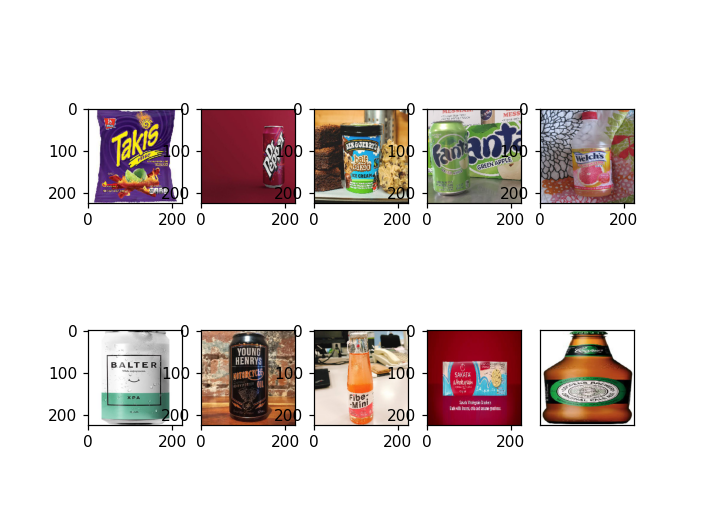

In [16]:
#X, Y = train_ds
(X, Y) = next(train_generator)
print(X.shape)
print(Y.shape)

plot_dataset(X[:10])
#print(Y[:10])

In [17]:
labelnames = list(train_generator.class_indices.keys())

for y_onehot in Y[:10]:
    idx = np.argmax(y_onehot, axis=0)
    print(labelnames[idx]) 

ausnack_51
audrink_107
ice_14
audrink_22
drink186
aubeer_14
aubeer_98
drink20
austeafood_000018
aubeer_34


## Load a pre-trained model and attach some fully-connected layers

In [18]:
emb_size = 128

img_input = keras.Input(shape=(224, 224, 3))
train_labels = keras.Input(shape=(train_classnum,))

final_output, side_output = my_model(img_input, train_labels, emb_size)
model = keras.Model(inputs=[img_input, train_labels], outputs=[final_output, side_output])
model.summary()

706
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[1][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           global_average_pooling2d[0][0]   
__________________________________________________________________________________________

## compile

In [19]:
lambda_centerloss = 0.01
initial_learning_rate = 0.005

optim = optimizers.SGD(lr=initial_learning_rate, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  loss_weights=[1, lambda_centerloss])

## Define data generation wrapper

In [20]:
def datagen_wrapper(gen, batch_size=64):
    dummy = np.zeros((batch_size, 1))
    #dummy2 = np.zeros((x_test.shape[0], 1))
    while True:
        (X, Y) = next(gen)    
        yield([X, Y], [Y, dummy])


## Prepare Tensorboard log

In [21]:
from datetime import date, time, datetime
import time

#datetimestr = datetime.now().__str__()
#timestamp = datetimestr.split()[0] + "_" + datetimestr.split()[1].split('.')[0]

epoch_time = int(time.time())

In [22]:
log_dir_rel = "logs/logs-{}".format(epoch_time)
#log_dir = os.path.abspath(log_dir_rel)
log_dir = os.path.abspath("logs/train_log")

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

print(log_dir)

/home/chieko/Projects/ImageRecognition2/ItemRecogCenterLoss/logs/train_log


In [23]:
# Validation Data for Tensorboard
x_tb, x_tb_label_list = create_testdata(datadir='train', tblog_dir=log_dir, metadatafile=_TB_METADATA)
y_tb = np.zeros((x_tb.shape[0], emb_size))

x_tb_label = [ train_generator.class_indices[label] for label in x_tb_label_list ]
print(x_tb_label)

[186, 186, 186, 186, 186, 186, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 634, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 117, 117, 117, 117, 117]


<IPython.core.display.Javascript object>


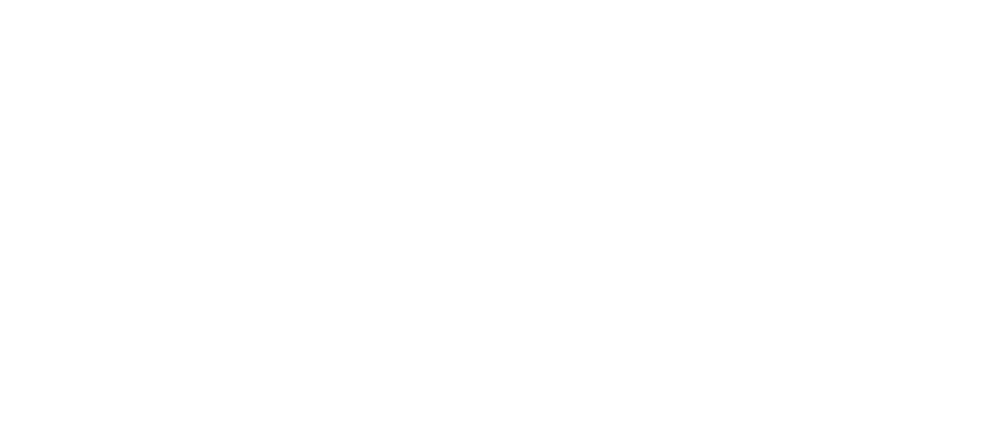

y_seq = [360  11 142 495 114 115 117 634 186 607], len = (10,)
Epoch 1/5
188/188 [==============================] - ETA: 0s - loss: 6.8223 - main_out_loss: 6.5572 - centerlosslayer_loss: 22.2841

<IPython.core.display.Javascript object>

188/188 [==============================] - 274s 1s/step - loss: 6.8223 - main_out_loss: 6.5572 - centerlosslayer_loss: 22.2841
Epoch 2/5
188/188 [==============================] - ETA: 0s - loss: 6.5909 - main_out_loss: 6.5486 - centerlosslayer_loss: 0.0326

<IPython.core.display.Javascript object>

188/188 [==============================] - 282s 1s/step - loss: 6.5909 - main_out_loss: 6.5486 - centerlosslayer_loss: 0.0326
Epoch 3/5
188/188 [==============================] - ETA: 0s - loss: 6.5829 - main_out_loss: 6.5411 - centerlosslayer_loss: 0.0149

<IPython.core.display.Javascript object>

188/188 [==============================] - 282s 1s/step - loss: 6.5829 - main_out_loss: 6.5411 - centerlosslayer_loss: 0.0149
Epoch 4/5
188/188 [==============================] - ETA: 0s - loss: 6.5754 - main_out_loss: 6.5340 - centerlosslayer_loss: 0.0089

<IPython.core.display.Javascript object>

188/188 [==============================] - 281s 1s/step - loss: 6.5754 - main_out_loss: 6.5340 - centerlosslayer_loss: 0.0089
Epoch 5/5
188/188 [==============================] - ETA: 0s - loss: 6.5684 - main_out_loss: 6.5273 - centerlosslayer_loss: 0.0109

<IPython.core.display.Javascript object>

188/188 [==============================] - 281s 1s/step - loss: 6.5684 - main_out_loss: 6.5273 - centerlosslayer_loss: 0.0109


In [24]:
epochs=5
steps_per_epoch = int(all_images/_BATCH_SIZE)
#steps_per_epoch = 5

reduced_model = keras.Model(inputs=model.input[0], outputs=model.get_layer('side_out').output)

model.fit(datagen_wrapper(train_generator, _BATCH_SIZE),
            steps_per_epoch=steps_per_epoch,
            #batch_size=_BATCH_SIZE,
            epochs=epochs,
            verbose=1,
            callbacks=[
                    tbProjector(reduced_model, x_tb, y_tb, log_dir, _TB_METADATA),
                    PCAPlotter(model, reduced_model, x_tb, x_tb_label, epochs, lambda_centerloss)])

In [ ]:
model_filename = "centerloss_" + str(epoch_time) + ".h5"

net.save(model_filename)
print("Trained model was saved into {}.".format(model_filename))

In [ ]:
embmodel_filename = "sideout_" + str(epoch_time) + ".h5"
embedding_model.save(embmodel_filename)
print("Trained model was saved into {}.".format(model_filename))